New red QSO Code

In [1]:
#Completeness checking step - list of objects with data for all 5 bands
import os

dataAddress = r"/home/elliesaga/Code/Work/YoRiS/data/Reds/images"

objects = list(os.listdir(dataAddress))

#list of complete objects
completeObjects = []

for object in objects:
    #we expect 10 files, 5 psfs and 5 images
    filesInObjectDirectory = len(list(os.listdir(f"{dataAddress}/{object}/")))
    if filesInObjectDirectory == 10:
        completeObjects.append(object)
    else:
        continue

print(f"{len(completeObjects)} objects out of {len(objects)} have data in all 5 bands")



146 objects out of 150 have data in all 5 bands


39633286363873846


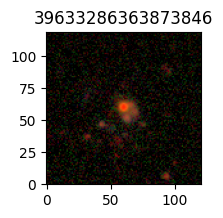

In [70]:
from astropy.visualization import make_lupton_rgb
import astropy.io.fits as pyfits
from matplotlib import pyplot as plt

#now, create colour images of each source and visually inspect for interfering foreground sources
index = 145
R = pyfits.open(f"{dataAddress}/{completeObjects[index]}/{completeObjects[index]}_HSC-I.fits")[1].data
G = pyfits.open(f"{dataAddress}/{completeObjects[index]}/{completeObjects[index]}_HSC-R.fits")[1].data
B = pyfits.open(f"{dataAddress}/{completeObjects[index]}/{completeObjects[index]}_HSC-G.fits")[1].data
image = make_lupton_rgb(R,G,B,stretch=0.5,Q=10)
print(f"{completeObjects[index]}")
fig,ax = plt.subplots(figsize=(2,2))
plt.title(f"{completeObjects[index]}")
ax.imshow(image,origin="lower")


In [87]:
#now saving images of all objects
import numpy as np
import matplotlib
#matplotlib.use('Agg')
imageAddress = r"/home/elliesaga/Code/Work/YoRiS/data/Reds/rgbimages"
contamCSV = r"/home/elliesaga/Code/Work/YoRiS/data/Reds/contaminationCheck.csv"
objects,contaminated = np.loadtxt(contamCSV,unpack=True,delimiter=",",skiprows=1,dtype=str)

for i, object in enumerate(objects):
    if contaminated[i] == " 1":
        continue
    else:
        #make image for each object
        R = pyfits.open(f"{dataAddress}/{object}/{object}_HSC-I.fits")[1].data
        G = pyfits.open(f"{dataAddress}/{object}/{object}_HSC-R.fits")[1].data
        B = pyfits.open(f"{dataAddress}/{object}/{object}_HSC-G.fits")[1].data
        image = make_lupton_rgb(R,G,B,stretch = 0.5,Q=10)
        plt.imshow(image)
        plt.savefig(f"{imageAddress}/{object}.png")
    
    

obj_No:
0
working on object 39627745474384020
Fitting using GaLight... ... ...


/home/elliesaga/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Deblending: 100%|██████████| 1/1 [00:00<00:00, 244.28it/s]


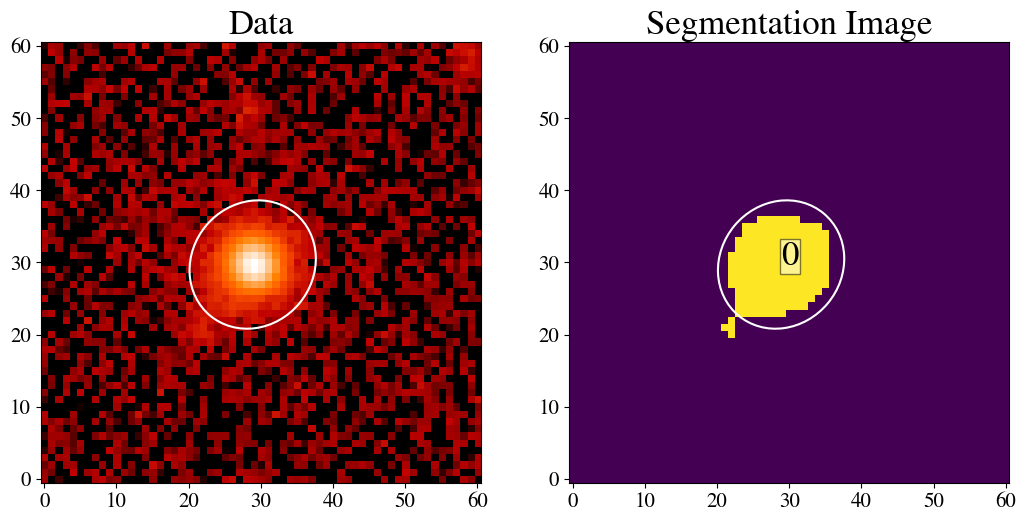

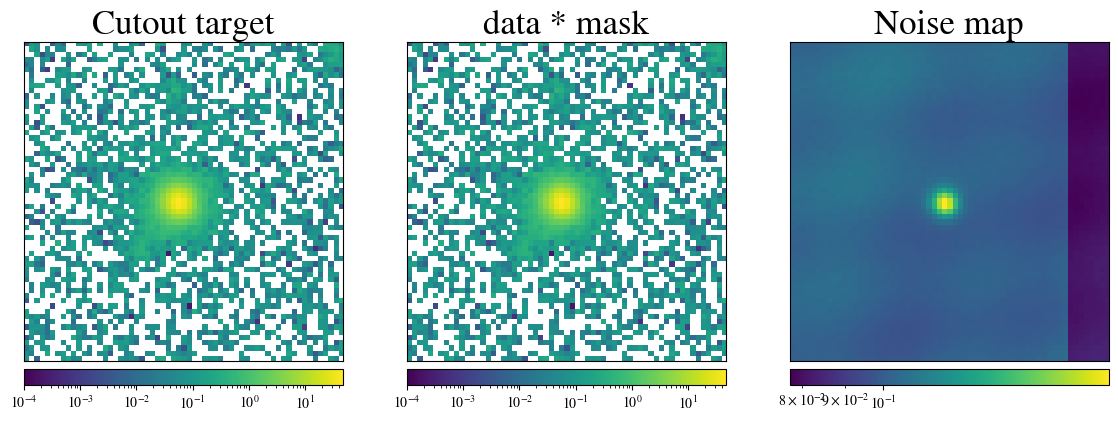

I band delta pixel:  0.1679999999999976


Deblending: 100%|██████████| 1/1 [00:00<00:00, 93.96it/s]


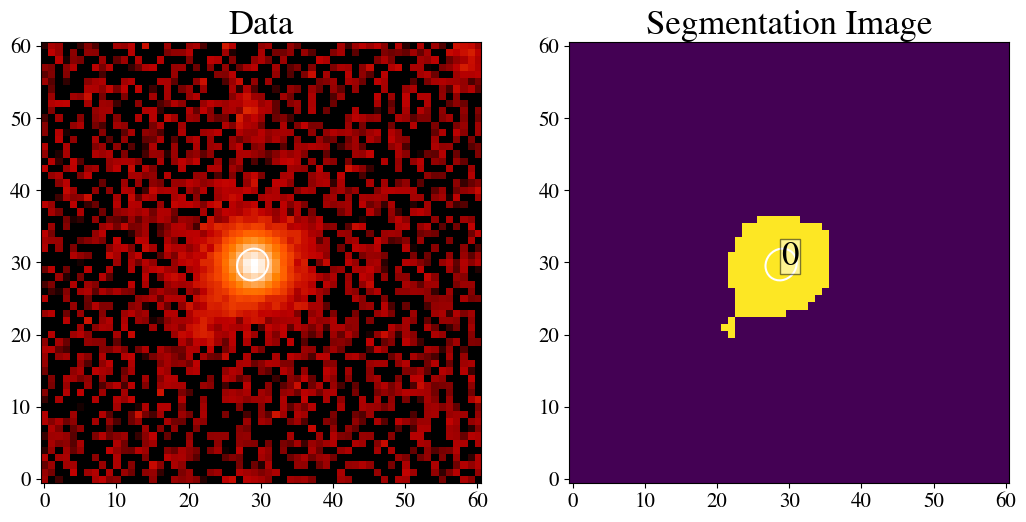

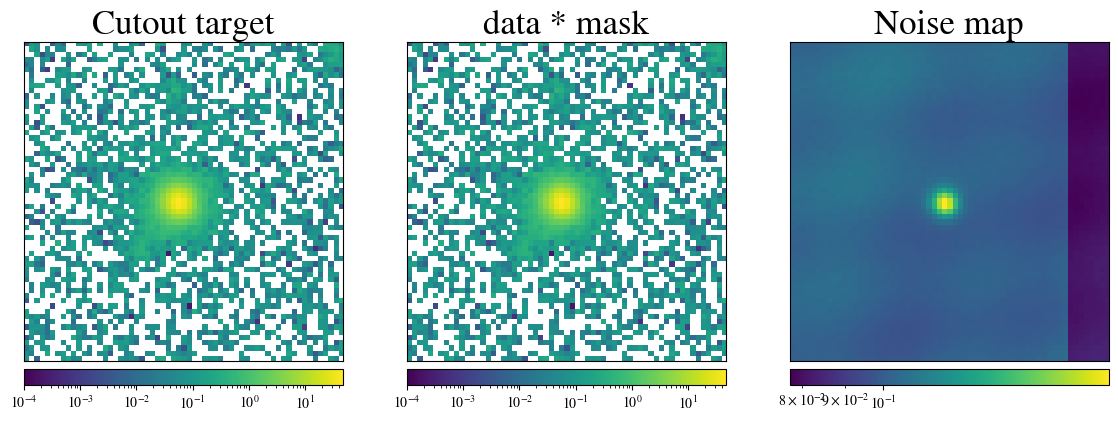

The negative PSF values are corrected as 0 values.
The data_process is ready to go to pass to FittingSpecify!
Staring fitting band-I... ... ...
The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


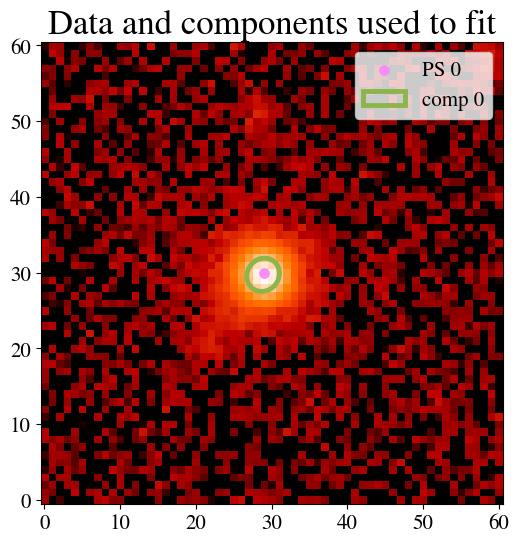

TypeError: 'bool' object is not iterable

In [4]:
#psf fitting
#VISTA Code
#need to try to find out what is causing multithreading 

import os


#!/usr/bin/env python3

# -*- coding: utf-8 -*-
"""
Created on Fri Mar 24 03:08:25 2023
@author: tang

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import astropy.io.fits as pyfits
import sys
from astropy.table import Table
import time
from glob import glob
from astropy.nddata import Cutout2D
import astropy.units as u
from astropy.coordinates import SkyCoord
#sys.path = sys.path[:-4]
#sys.path.append('/Users/tang/Documents/Binary_quasar/codes/galight/')
#print(sys.path)
#from galight.tools.astro_tools import plt_fits,read_fits_exp,read_pixel_scale
from galight.tools.cutout_tools import cut_center_auto
from galight.data_process import DataProcess
from astropy.wcs import WCS
from galight.fitting_specify import FittingSpecify
from galight.fitting_process import FittingProcess
from galight.tools.measure_tools import mask_obj   
from galight.tools.measure_tools import sort_apertures
from multiprocessing import Pool
import time
#matplotlib.use("agg")
telescope = 'HSC'

import sys


cataloguePath = '/home/elliesaga/Code/Work/YoRiS/data/Reds/RedQSOCatalague.csv'
saveTo = '/home/elliesaga/Code/Work/YoRiS/testing/VISTA/'


if telescope == 'VISTA': #bands = 'KJH'
    pixel_size = 0.339 #arcsec/pix
    data_exten = 1
    bands = 'K'
    lband = 'K' #The band fitting first and can also fit n and Re for other band.
    cut = False
    size = 180
    size = size/pixel_size

elif telescope == 'DECam': #bands = 'griz'
    pixel_size = 0.262 #arcsec/pix
    bands = 'GRIZ'
    cut = False
    data_exten = 0

elif telescope == 'HSC':
    pixel_size = 0.168
    bands = 'I'
    lband = 'I' #The band fitting first and can also fit n and Re for other band.
    cut = False
    data_exten = 1

fix_n, fix_re = True, True
save_fits_images = False #save fits images? This includes the model, the host only image, and the residual image
fitting_level='shallow' #shallow, deep

catalog = pd.read_csv(cataloguePath)



obj_list = [39627745474384020]



maindir = os.getcwd()
#%%Some settings for the fitting
#def serial_task(task_idx):
waitTime = 10 #wait time in seconds
for obj in obj_list:
    os.chdir(maindir)
    point_source_num = 1
    obj_No = list(catalog['TARGETID']).index(obj)
    print("obj_No:")
    print(obj_No)
    obj_name,ra,dec= str(catalog.iloc[obj_No]['TARGETID']), catalog.iloc[obj_No]['ra_desi'], catalog.iloc[obj_No]['dec_desi']

    # if object_id in ['234311.93-005034.3']:

    #     point_source_num = 2
    print('working on object %s' %obj_name)
    #%%use galight to analyze:
    print('Fitting using GaLight... ... ...')
    
    data_process_list = []
    headers = []
    for band,band_count in zip(bands,range(len(bands))):
        dataDirectory = f"/home/elliesaga/Code/Work/YoRiS/data/Reds/images/{obj_name}"
        fitsFile = pyfits.open(f'{dataDirectory}/{obj_name}_HSC-{band}.fits')  
        header = fitsFile[data_exten].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']
        plt.imshow(fitsFile[1].data)
        if 'NAXIS3' in header:
            print("Remove the third axis from the header.")
            header['NAXIS'] = 2
            del header['NAXIS3']

        w = WCS(header)
        if cut: 
            cut_file = Cutout2D(fitsFile[data_exten].data, position=SkyCoord(ra*u.deg,dec*u.deg), size=(size,size), wcs = w)
            fov_image = cut_file.data
            target_pos = cut_file.center_cutout
            print('A cutout will be made cetered at (ra=%s, dec=%s) with size (%s, %s)'%(ra,dec,size,size))

        else:
            fov_image = fitsFile[data_exten].data
            #target_pos = (header['CRVAL1'],header['CRVAL2'])
            if telescope == 'HSC':
                target_pos = [ra, dec]
            else:
                target_pos = (fov_image.shape[0]/2, fov_image.shape[1]/2)

        file_header0 = fitsFile[0].header
        headers.append(file_header0)

        #try:

        #    FLUXMAG0 = file_header0['FLUXMAG0']

        #    zp =  2.5 * np.log10(FLUXMAG0)   # This is something Xuheng can't make sure.

        #except:
        if telescope == 'HSC':

            PSF = pyfits.getdata(f'{dataDirectory}/{obj_name}_HSC-{band}_psf.fits')

            zp = 27.0
            
            data_process = DataProcess(fov_image = fitsFile[1].data, fov_noise_map = fitsFile[3].data ** 0.5, target_pos = [ra, dec],

                                            pos_type = 'wcs', header = fitsFile[1].header, 

                                            rm_bkglight = False, if_plot=False, zp = zp)

        elif telescope == 'VISTA':
            PSF = pyfits.getdata(f'{psfDirectory}{VISTAFileNameFormat(obj_name,band,True)}')

            exptime = 90

            zp = 27.0
            
            

        elif telescope == 'DECam':

            PSF = pyfits.getdata(f'{obj_name}/{obj_name}_PSF_{band}_stacked.fits')

            if band == 'G':

                exptime = 90

                zp = 25.2

            elif band == 'R':

                exptime = 90

                zp = 25.3

            elif band == 'I':

                exptime = 90

                zp = 25.3

            elif band == 'Z':

                exptime = 90

                zp = 25.0
            else:

                raise ValueError(f'{band} band is not supported!')
            data_process = DataProcess(fov_image = fov_image, fov_noise_map = fitsFile[3].data ** 0.5, target_pos = target_pos, header = header, #pos_type = 'wcs',
                                   rm_bkglight = True, if_plot=True, zp = zp)  #zp use 27.0 for convinence. removed exptime = exptime
        #Some default settings
        
        ps_pix_center_list = None #default - None
        
        npixels = 15
        thresh=2.5
        nsigma = 2.8
        if obj_name in ['ULASJ2224-0015']:
            cut_radius = 35
        if obj_name in ['ULASJ2315+0143']:
            nsigma = 1.5
        if obj_name in ['ULASJ1002+0137']:
            npixels = 10
            thresh = 1.0
            nsigma = 1.5
            #if telescope == 'DECam':
                #fix the PS position to the image center

            #    ps_pix_center_list = [[0,0]] 

        # if obj_name in ['ULASJ0144+0036','ULASJ1002+0137']:

        #     data_process.generate_target_materials(radius=None,if_plot=True, nsigma=2.0, npixels = 10, thresh=1.0, use_moments=False)

        data_process.generate_target_materials(radius=None,if_plot=True, nsigma=nsigma, npixels=npixels, thresh=thresh, use_moments=False)
        data_process.PSF_list = [PSF]
        print(band, 'band delta pixel: ', data_process.deltaPix)

        data_process_list.append(data_process)
    #%% Determining the common settings for all bands, including cutout radius and apertures.
    l_idx = [i for i in range(len(bands)) if bands[i] == lband][0]  #The first index to run
    os.chdir(saveTo)
    run_list = [i for i in range(len(bands))]
    
    del(run_list[l_idx])
    run_list = [l_idx] + run_list  #The list define the order to run
    cut_radius = np.median([int(len(data_process_list[i].target_stamp)/2) for i in range(len(data_process_list))]) #* 1.4
    for i in range(len(bands)):
        # if obj_name in ['ULASJ0144+0036','ULASJ1002+0137']:
        #     data_process_list[i].generate_target_materials(radius=cut_radius, create_mask = True, nsigma=2.0, npixels = 10, thresh=1.0, exp_sz= 1.2, if_plot=True)
        data_process_list[i].generate_target_materials(radius=cut_radius, create_mask = False, nsigma=nsigma, npixels=npixels, exp_sz= 1.2, if_plot=True, thresh=thresh)

        data_process_list[i].checkout()
    apertures = data_process_list[l_idx].apertures
    for i in run_list:
        #print("Waiting...")
        #time.sleep(waitTime)
        if i != l_idx:

            covers = mask_obj(data_process_list[i].target_stamp, apertures, if_plot=False, sum_mask = True)

            for j in range(len(data_process_list[i].apertures)):

                new_cover = mask_obj(data_process_list[i].target_stamp, [data_process_list[i].apertures[j]], if_plot=False, sum_mask = True)

                positions = [apertures[k].positions for k in range(len(apertures)) ]

                dists = [ np.sqrt((np.sum((data_process_list[i].apertures[j].positions - 

                                positions[k])**2))) for k in range(len(apertures)) ]

                cond1 = np.sum(covers - new_cover*covers) > np.sum(1-new_cover)/2 #If 1/2 of the area covered by the aperture is new)

                cond2 = np.sum( (1-new_cover) * covers ) > np.sum(1-new_cover )*4/5 #If 1/5 of the new aper is not overlap with pervious aper

                cond3 = np.min(dists) > 4  #If center offset above 4 pixel

                if cond1 and cond2 and cond3 :

                    apertures.append(data_process_list[i].apertures[j])

    

    apertures = sort_apertures(data_process_list[0].target_stamp, apertures)    #%%

    fit_sepc_l, fit_run_l = [None]*5, [None]*5

    results_path = f'{obj_name}/fitting_results'

    if not os.path.exists(results_path):
    # Create a new directory because it does not exist
        os.makedirs(results_path)

    for i in run_list:  
        band = bands[i]

        print("Staring fitting band-"+band+"... ... ...")
        data_process_list[i].apertures = apertures #Pass apertures to the data
        
        fit_sepc_l[i] = FittingSpecify(data_process_list[i])

        fix_n_list, fix_Re_list = None, None #Not fixing the sersic parameters for fitting

        #fix_n_list, fix_Re_list = [[0,sersic_n]],[[0,sersic_R]]
        #if i != l_idx: #use n and R from i band
        #    if fix_n == True:
        #        fix_n_list = [[0,fit_run_l[l_idx].final_result_galaxy[0]['n_sersic'] ]]
        #    if fix_re == True:
        #        fix_Re_list = [[0,fit_run_l[l_idx].final_result_galaxy[0]['R_sersic'] ]]

        fit_sepc_l[i].prepare_fitting_seq(point_source_num = point_source_num, supersampling_factor=3,point_source_supersampling_factor=3, 

                                        fix_n_list= fix_n_list, fix_Re_list=fix_Re_list, ps_pix_center_list = ps_pix_center_list,fix_center_list=True)

        fit_sepc_l[i].plot_fitting_sets('{0}/fitting_results/{1}-fitconfig-band-{2}.png'.format(obj_name,obj_name,band.lower()))
        fit_sepc_l[i].build_fitting_seq()
        fit_run_l[i] = FittingProcess(fit_sepc_l[i], savename = '{0}/fitting_results/{1}-result-band-{2}'.format(obj_name,obj_name,band.lower()), fitting_level=fitting_level)
        fit_run_l[i].run(algorithm_list = ['PSO'], setting_list=[{'sigma_scale':0.8,'n_particles':50,'n_iterations':200}])

        if fit_run_l[i].image_ps_list != []:
            fit_run_l[i].plot_final_qso_fit(save_plot=True, target_ID= obj_name +'-'+ band ) #show_plot=False

        else:
            fit_run_l[i].plot_final_galaxy_fit(save_plot=True, target_ID= obj_name +'-'+ band )

            

        fit_run_l[i].cal_astrometry()
        fit_run_l[i].dump_result()

        #print(fit_run_l[i].fitting_specify_class.target_pos)
        #fit_run.fitting_specify_class.segm_deblend
        #Save the fits files
        
        if save_fits_images:
            header = headers[i]
    
            host = fit_run_l[i].flux_2d_out['data'] - fit_run_l[i].flux_2d_out['model'] + fit_run_l[i].image_host_list[0]
    
            pyfits.PrimaryHDU(host,header=header).writeto(f'{obj_name}/fitting_results/fit_image_{obj_name}_{telescope}-{band}_host.fits', overwrite=True)
    
            for key, name in zip(fit_run_l[i].flux_2d_out,['data', 'model', 'sersic', 'data-model=residual']):
                pyfits.PrimaryHDU(fit_run_l[i].flux_2d_out[key],header=header).writeto(f'{obj_name}/fitting_results/fit_image_{obj_name}_{telescope}-{band}_{name}.fits', overwrite=True)
        #continue


            #Script to remove the fitted target

            # if len(fit_run_l[i].image_host_list) > 1 and point_source_num>0: #if more than 1 obj is detected in the fov

            #     fit_run_l[i].targets_subtraction(save_fitsfile=True, sub_gal_list=list(range(len(fit_run_l[i].image_host_list)))[1:], sub_qso_list=[0])

            # else:

            #     fit_run_l[i].targets_subtraction(save_fitsfile=True, sub_qso_list=[0])

    # for n in range(len(obj_list)): #len(obj_list)

    # for n in range(10,len(obj_list)): #len(obj_list)

    #     serial_task(n)
